In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [26]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last Date in DB: 2017-08-23

One year ago: 2016-08-23 



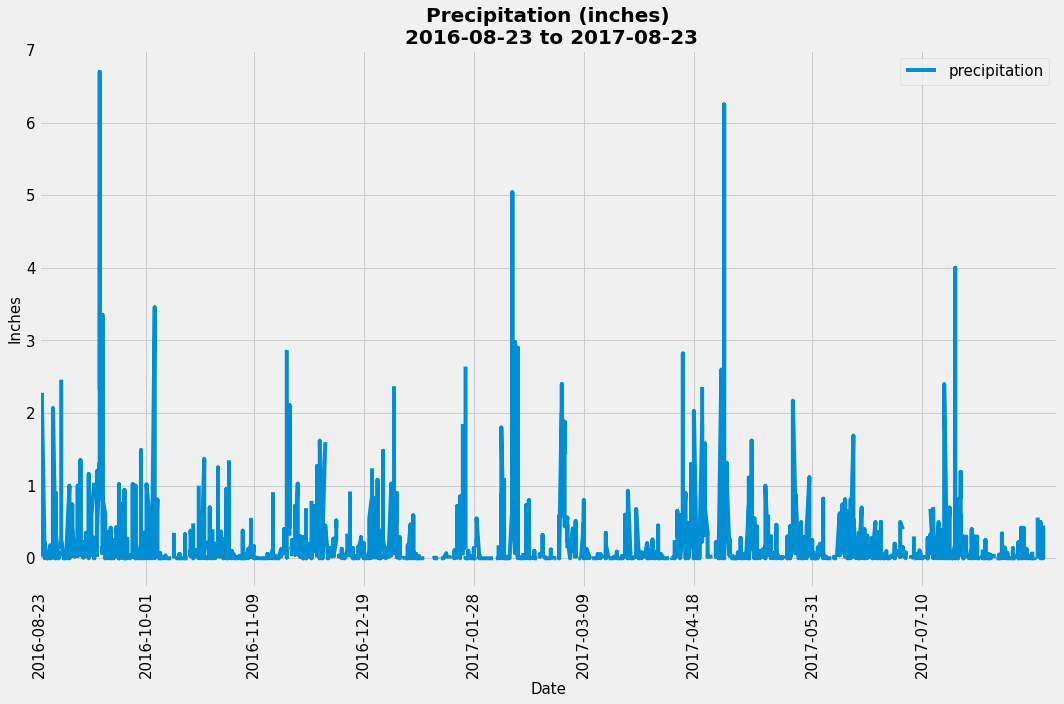

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_data_point = session.query(func.max(Measurement.date)).first()[0]

year = int(last_data_point.split('-')[0])
mth = int(last_data_point.split('-')[1])
date = int(last_data_point.split('-')[2])

last_date_in_db = dt.date(year, mth, date)
print("Last Date in DB:", last_date_in_db)

# Calculate the date 1 year ago from the last data point in the database

one_year_ago = last_date_in_db - dt.timedelta(days=365)
print("\nOne year ago:", one_year_ago,"\n")

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23').all()
last_year
# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")
last_year_df.head()

# Sort the dataframe by date

sorted_df = last_year_df.sort_values(by = "date")
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 10))
plt.plot(sorted_df.index, sorted_df['prcp'])

plt.legend(['precipitation'], loc="upper right",fontsize=15)
# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

plt.xticks(xloc, rotation='vertical',fontsize=15)

#lables and titles 
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation (inches)\n {one_year_ago} to {last_data_point}",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# xlim and ylim
plt.xlim(0,370)
plt.ylim(-0.4,7)

# Save Figure
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.distinct(Measurement.station)).count()
print(station_count)

9


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ste = [Station.station, func.count(Measurement.station)]
session.query(*ste).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == ste[0]).all()

[(53.0, 87.0, 73.09795396419437)]

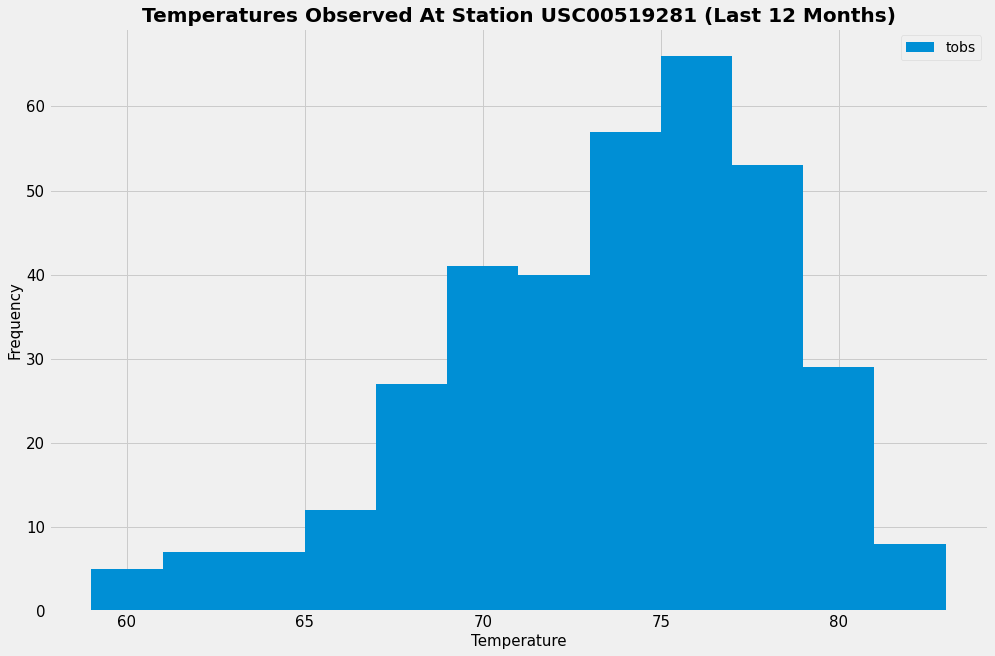

<Figure size 432x288 with 0 Axes>

In [40]:
# Choose the station with the highest number of temperature observations.

session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(one_year_ago,last_data_point),\
                   Measurement.station == 'USC00519281').all()

plt.figure(figsize=(15,10))
plt.hist(np.ravel(results), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)',fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

# Save Figure
plt.savefig("Images/station-histogram.png")
# Show plot
plt.show()
plt.tight_layout()

## Bonus Challenge Assignment

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
yearly_temp = calc_temps('2016-08-23', '2017-08-23')
yearly_temp

[(58.0, 74.59058295964125, 87.0)]

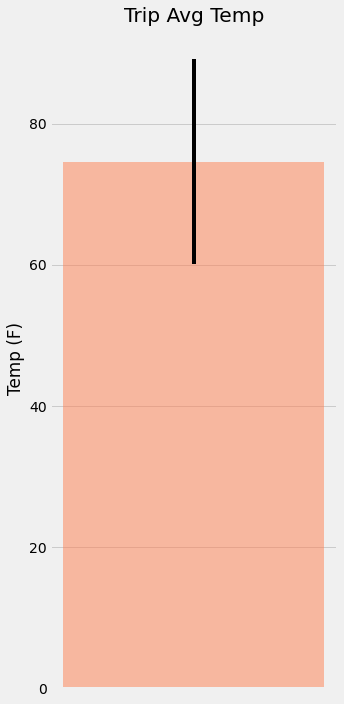

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tempmax = yearly_temp[0][2]
tempmin = yearly_temp[0][0]
peak_to_peak = tempmax - tempmin
tempavg = yearly_temp[0][1]  

# Plot
fig, ax = plt.subplots(figsize = (5, 10)) 

# Create figure & axis objects 
ax.bar(x = 1, height = tempavg, yerr = peak_to_peak/2, width = 0.4,color = 'coral', alpha = 0.5) # Plotting
ax.set_xticks([0]) 
plt.yticks(size=14)

# "Labels"
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature.png", bbox_inches = 'tight')
plt.tight_layout()
plt.show()

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_results = session.query(Measurement.station, Station.name, Station.latitude,\
              Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
        filter(Measurement.station == Station.station,\
               Measurement.date.between(one_year_ago, last_data_point)).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).\
        all()

print(rainfall_results)


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.19894886363636372), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45064024390243923), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.14142857142857151), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12543396226415093), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.12105095541401273), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.044818941504178235), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765)]


In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2018, 1, 7)
# Use the start and end date to create a range of dates

rangeofdates = pd.date_range(start_date, periods=7).tolist()

# Stip off the year and save a list of %m-%d strings
dates = []
for date in rangeofdates:
    dates.append(dt.datetime.strftime(date, '%m-%d'))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date))

print("Chosen Dates: Aug 23 to Aug 29 (7 day trip)")
for normal in normals:
    print(normal)

Chosen Dates: Aug 23 to Aug 29 (7 day trip)
[(62.0, 69.15384615384616, 77.0)]
[(60.0, 69.39622641509433, 77.0)]
[(62.0, 68.9090909090909, 77.0)]
[(58.0, 70.0, 76.0)]
[(56.0, 67.96428571428571, 76.0)]
[(61.0, 68.96491228070175, 76.0)]
[(57.0, 68.54385964912281, 76.0)]


In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_list = []
for normal in normals:
    normal_list.append(np.ravel(normal))
trip_normals_df = pd.DataFrame(normal_list, columns = ['tmin', 'tavg', 'tmax'])
trip_normals_df.index = [str(date.strftime('%Y-%m-%d')) for date in rangeofdates]
trip_normals_df

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


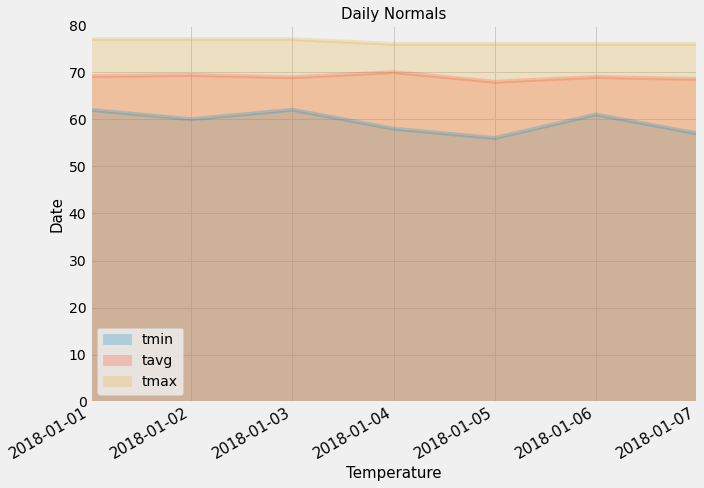

In [51]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,7))
trip_normals_df.plot(kind='area', stacked=False, alpha=0.25, ax=ax)
plt.title("Daily Normals",fontsize=15)
plt.ylabel("Date",fontsize=15)
plt.xlabel("Temperature",fontsize=15)

plt.ylim(0,80)
plt.xlim(0,4)
plt.yticks(size=14)
plt.xticks(np.arange(7), trip_normals_df.index,fontsize=15)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right" )

plt.savefig("Images/daily_normals.png", bbox_inches = 'tight')
plt.tight_layout()
plt.show()